# Data Preprocessing

<h2>Table of Contents</h2>

  - [1. Download data](#1.-download-data)
  - [2. Extract data](#2.-extract-data)
  - [3. Transform data](#3.-transform-data)
    - [3.1. Create Target column](#3.1.-create-target-column)
    - [3.2. Data Preprocessing](#3.2.-data-preprocessing)
  - [4. Load data](#4.-load-data)
  - [5. Visualize some plot](#5.-visualize-some-plot)



## 1. Download data

**EEG data for Mental Attention State Detection**

URL: https://www.kaggle.com/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/data

In [1]:
import kagglehub
print("Kaggle hub version:", kagglehub.__version__)

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

Kaggle hub version: 0.3.4
Path to dataset files: /home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1


In [2]:
# Import Librabies
import os 
from scipy.io import loadmat
from scipy.signal import butter, lfilter
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# path = "/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1"
files = os.listdir(path)
print(f"Folder: {files}")
for file in files:
    new_path = os.path.join(path, file)
    print(f"Folder {file} has {len(os.listdir(new_path))} files")

Folder: ['eeg data', 'EEG Data']
Folder eeg data has 1 files
Folder EEG Data has 34 files


In [4]:
# Join file paths and sort
data_path = os.path.join(path, 'EEG Data')
data_files = [os.path.join(data_path, file) for file in os.listdir(data_path)]
data_files.sort(key=lambda x: int(x.split('eeg_record')[1].split('.mat')[0]))
# Verify sorted paths
for file in data_files[:3]:
    print(file) 

/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record1.mat
/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record2.mat
/home/thangquang/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1/EEG Data/eeg_record3.mat


## 2. Extract data

In [5]:
# load first .mat file
mat_data = loadmat(data_files[0])

print(mat_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'o'])


According to the dataset's context, the raw data is stored in 'o', and each column in the 'o' data represents a data channel.

In [6]:
o_data = mat_data['o']
o_data

array([[(array(['201410092013.D091BB44'], dtype='<U21'), array([], dtype='<U1'), array([[308868]], dtype=int32), array([[128]], dtype=uint8), array([[0],
               [0],
               [0],
               ...,
               [0],
               [0],
               [0]], dtype=uint8), array([[2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 1.4000e+01,
                1.5360e+00],
               ...,
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01],
               [2.0140e+03, 1.0000e+01, 9.0000e+00, 2.0000e+01, 5.4000e+01,
                1.6494e+01]]), array([[  3.,   0., 463., ...,   0.,   0.,   0.],
               [ 

The raw data is contained in `o.data`, which is an array of size {number-of-samples}x25. Thus, `o.data(:,i)` comprises one data channel, which we will focus on.

In [7]:
columns = ['ED_COUNTER', 'ED_INTERPOLATED', 'ED_RAW_CQ', 'ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1',
           'ED_O2', 'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4', 'ED_GYROX', 'ED_GYROY', 'ED_TIMESTAMP',
           'ED_ES_TIMESTAMP', 'ED_FUNC_ID', 'ED_FUNC_VALUE', 'ED_MARKER', 'ED_SYNC_SIGNAL']

data = o_data[0][0]['data']
df = pd.DataFrame(data, columns=columns)
df = df.reset_index()
df = df.rename(columns = {'index': 't'})
print('Number of rows:', len(df))
df.head()

Number of rows: 308868


,t,ED_COUNTER,ED_INTERPOLATED,ED_RAW_CQ,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,...,ED_F8,ED_AF4,ED_GYROX,ED_GYROY,ED_TIMESTAMP,ED_ES_TIMESTAMP,ED_FUNC_ID,ED_FUNC_VALUE,ED_MARKER,ED_SYNC_SIGNAL
0,0,3.0,0.0,463.0,4440.000000,4417.948718,5390.769231,3833.846154,4019.487179,4656.410256,...,4335.384615,4563.589744,1573.0,1726.0,764.304,0.031277,0.0,0.0,0.0,0.0
1,1,4.0,0.0,0.0,4439.487179,4417.948718,5389.230769,3830.256410,4020.000000,4658.974359,...,4331.794872,4566.666667,1570.0,1727.0,764.304,0.031277,0.0,0.0,0.0,0.0
2,2,5.0,0.0,447.0,4438.974359,4414.871795,5385.641026,3829.743590,4017.948718,4655.897436,...,4333.846154,4557.948718,1567.0,1726.0,764.304,0.031277,0.0,0.0,0.0,0.0
3,3,6.0,0.0,500.0,4438.974359,4410.256410,5381.025641,3831.794872,4016.410256,4649.230769,...,4334.358974,4552.820513,1564.0,1723.0,764.304,0.031277,0.0,0.0,0.0,0.0
4,4,7.0,0.0,424.0,4439.487179,4407.179487,5378.461538,3831.282051,4019.487179,4647.692308,...,4334.358974,4546.666667,1565.0,1720.0,764.304,0.031277,0.0,0.0,0.0,0.0


In [8]:
df['ED_INTERPOLATED'].sum()

0.0

| ID  | Channel Name        | Meaning                                                   |
|-----|---------------------|-----------------------------------------------------------|
| 1   | `'ED_COUNTER'`       | Counter for collected data samples.                       |
| 2   | `'ED_INTERPOLATED'`   | Data interpolation state.                                 |
| 3   | `'ED_RAW_CQ'`         | Raw data quality from sensors.                            |
| 4–17| EEG Channels        | Channels containing EEG data (electroencephalography).    |
| 18  | `'ED_GYROX'`          | Data from gyroscope sensor (X-axis).                      |
| 19  | `'ED_GYROY'`          | Data from gyroscope sensor (Y-axis).                      |
| 20  | `'ED_TIMESTAMP'`      | Timestamp.                                                |
| 21  | `'ED_ES_TIMESTAMP'`   | Event timestamp.                                          |
| 22  | `'ED_FUNC_ID'`        | Function ID code.                                         |
| 23  | `'ED_FUNC_VALUE'`     | Function value.                                           |
| 24  | `'ED_MARKER'`         | Event marker.                                             |
| 25  | `'ED_SYNC_SIGNAL'`    | Synchronization signal.                                   |


## 3. Transform data

### 3.1. Create Target column

Since the sampling frequency is 128 Hz (128 data points are taken each second), the column `t` represents the sampling times (starting from 0).

According to the dataset's author, during the first 10 minutes of each experiment, the participant is in a `focused` state, the next 10 minutes are in an `unfocused` state, and after that, the participant is in a `drowsy` state.

Therefore, if we convert to sampling times, the formula for the first sample at minute $i$ is $i \times 128 \times 60$, where $128$ is the sampling frequency.

In [9]:
def get_state(t):
    if t <= 10 * 128 * 60:
        return 'focused'
    elif t > 20 * 128 * 60:
        return 'drownsy'
    else:
        return 'unfocused'

Extract data from columns 4 to 17, representing 14 channels, and then create a `state` column.

In [10]:
channel_columns = ['t']  # get i's sample
channel_columns.extend(df.columns[4:18])  # 14 channels
df_channels = df[channel_columns].copy()
df_channels['state'] = df_channels['t'].apply(get_state)
df_channels.head()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state
0,0,4440.000000,4417.948718,5390.769231,3833.846154,4019.487179,4656.410256,4742.051282,4415.384615,4538.461538,4308.205128,4125.641026,4283.589744,4335.384615,4563.589744,focused
1,1,4439.487179,4417.948718,5389.230769,3830.256410,4020.000000,4658.974359,4738.974359,4414.871795,4535.897436,4308.205128,4136.410256,4284.615385,4331.794872,4566.666667,focused
2,2,4438.974359,4414.871795,5385.641026,3829.743590,4017.948718,4655.897436,4734.358974,4414.871795,4537.435897,4308.205128,4152.820513,4283.076923,4333.846154,4557.948718,focused
3,3,4438.974359,4410.256410,5381.025641,3831.794872,4016.410256,4649.230769,4730.256410,4409.743590,4535.384615,4308.717949,4157.948718,4283.076923,4334.358974,4552.820513,focused
4,4,4439.487179,4407.179487,5378.461538,3831.282051,4019.487179,4647.692308,4729.230769,4408.205128,4526.666667,4307.179487,4157.948718,4285.641026,4334.358974,4546.666667,focused


### 3.2. Data Preprocessing

The preprocessing of EEG data involves several steps to clean and prepare the data for analysis. The following steps are performed:

1. **Bandpass Filtering**: Apply a bandpass filter to retain important frequencies within the EEG range, typically from 0.5 Hz to 40 Hz, and remove frequencies outside this range.

2. **Line Noise Removal**: Use notch filters to eliminate noise from alternating current (AC) power sources, usually at 50 Hz or 60 Hz, depending on the region.

3. **Re-referencing (Common Average Reference)**: Subtract the mean of all channels from each channel to reduce noise and improve signal quality.

4. **Epoching**: Segment the data into epochs based on the sampling frequency to facilitate further analysis.

These preprocessing steps help in enhancing the quality of the EEG data, making it more suitable for subsequent analysis and interpretation.

In [11]:
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, iirnotch

# Define helper functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data, axis=0)

def notch_filter(data, fs, freq=50.0, quality=30.0):
    b, a = iirnotch(freq, quality, fs)
    return lfilter(b, a, data, axis=0)

# Configuration parameters
fs = 128  # Sampling frequency
lowcut = 0.5  # Low cut-off frequency for band-pass filter
highcut = 40  # High cut-off frequency for band-pass filter

channel_columns = list(df_channels.columns[1:-1])

# DataFrame processing function
def preprocess_eeg_dataframe(df, channel_cols):
    """
    Preprocess EEG data from DataFrame.
    Args:
        df (DataFrame): DataFrame containing EEG data.
        channel_cols (list): List of EEG channel column names (e.g., ['ED_AF3', 'ED_F7', ...]).
    Returns:
        df (DataFrame): DataFrame after preprocessing.
    """
    df = df.copy()

    # Extract EEG data
    eeg_data = df[channel_cols].values  # Extract EEG data (numpy array)

    # Apply band-pass filter
    eeg_data = butter_bandpass_filter(eeg_data, lowcut, highcut, fs)

    # Apply 50Hz notch filter
    eeg_data = notch_filter(eeg_data, fs, freq=50.0)

    # Re-reference (Common Average Reference)
    mean_ref = np.mean(eeg_data, axis=1, keepdims=True)
    eeg_data = eeg_data - mean_ref

    # Epoching
    epochs = np.arange(len(df)) // fs

    # Convert back to DataFrame
    df[channel_cols] = eeg_data
    df['epoch'] = epochs

    return df

In [12]:
filtered_df = preprocess_eeg_dataframe(df_channels, channel_columns)
filtered_df.head()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state,epoch
0,0,1.120340,-2.755780,168.244217,-105.427892,-72.796369,39.160403,54.214172,-3.206491,18.427667,-22.046238,-54.136907,-26.373070,-17.268695,22.844642,focused,0
1,1,4.395542,-11.145136,678.158097,-425.811135,-293.500294,158.336547,218.050728,-13.052816,73.828406,-88.935734,-216.451402,-106.203807,-70.300834,92.631838,focused,0
2,2,6.494747,-17.747327,1046.694998,-659.664355,-453.676420,245.279852,334.821618,-20.378686,113.255591,-137.419082,-326.880726,-163.926070,-109.830783,142.976643,focused,0
3,3,5.251597,-16.418738,846.355308,-536.619917,-368.815432,198.018113,267.332731,-17.169025,91.628916,-110.896668,-248.953320,-132.836556,-89.212671,112.335662,focused,0
4,4,5.353299,-15.730481,636.604121,-403.716893,-278.834111,145.719002,198.516042,-14.633237,68.910647,-82.251690,-173.925660,-99.220136,-64.648660,77.857758,focused,0


In [13]:
filtered_df.describe()

,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,epoch
count,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000,308868.000000
mean,154433.500000,0.012999,-0.011797,-0.013970,0.013116,0.012858,-0.013409,-0.013841,-0.010592,-0.012447,0.012516,0.013027,0.013008,0.012725,-0.014193,1206.015631
std,89162.655809,54.979073,49.018457,59.648644,55.285711,51.990931,51.965287,63.918820,55.264314,49.842356,48.608761,55.142823,54.159564,50.136071,55.544730,696.583200
min,0.000000,-2641.626653,-1159.924574,-1927.091335,-2471.866956,-2532.044644,-1351.268160,-1489.463644,-1222.969387,-1230.182618,-1120.658081,-2104.070414,-1357.646791,-1200.348231,-1295.780439,0.000000
25%,77216.750000,-4.476769,-6.800051,-6.536735,-4.543400,-4.447934,-8.104833,-7.404733,-9.120086,-6.679451,-4.654489,-5.225270,-4.412736,-4.321939,-6.122918,603.000000
50%,154433.500000,0.034484,-0.073813,-0.082145,0.041194,0.037394,0.237673,-0.148298,-0.070903,0.024453,0.021806,-0.037149,0.023324,0.022906,-0.074694,1206.000000
75%,231650.250000,4.585215,6.672849,6.382949,4.664661,4.543459,8.202901,7.164290,8.762660,6.706019,4.768791,5.329090,4.522938,4.429341,5.990414,1809.000000
max,308867.000000,1410.684517,1489.879352,1804.692181,1414.755818,1270.727306,1255.812716,2097.379971,1953.158891,1848.743713,1170.742067,1412.388465,1409.995458,1246.280657,2038.171927,2413.000000


Finally, the function to extract data from a .mat file to a pd.DataFrame will be implemented like this:

In [14]:
def extract_data(file_path):
      mat_data = loadmat(file_path)
      data = mat_data['o'][0][0]['data']
      columns = ['ED_COUNTER', 'ED_INTERPOLATED', 'ED_RAW_CQ', 'ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 'ED_T7', 'ED_P7', 'ED_O1',
                     'ED_O2', 'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4', 'ED_F8', 'ED_AF4', 'ED_GYROX', 'ED_GYROY', 'ED_TIMESTAMP',
                     'ED_ES_TIMESTAMP', 'ED_FUNC_ID', 'ED_FUNC_VALUE', 'ED_MARKER', 'ED_SYNC_SIGNAL']

      df = pd.DataFrame(data, columns=columns)
      df = df.reset_index()
      df = df.rename(columns={'index': 't'})
      
      channel_columns = ['t']
      channel_columns.extend(df.columns[4:18])
      df_chanels = df[channel_columns].copy()
      df_chanels['state'] = df_chanels['t'].apply(get_state)
      
      # Preprocess the data
      filtered_df = preprocess_eeg_dataframe(df_chanels, channel_columns[1:])
      
      return filtered_df

## 4. Load data

In [15]:
# extract all 34 experiments and save to CSV file
flag = False # check missing value
for i, file_path in enumerate(data_files):
    new_df = extract_data(file_path=file_path)

    have_missing_value = new_df.isnull().sum().sum()
    if have_missing_value:
        print(f"File {i} has missing value")
        flag = True
    new_df.to_csv(f'data/extracted_eeg{i}.csv', index=False)
if flag:
    print("Missing data detected")
else:
    print("There is no missing value")

There is no missing value


In [16]:
# Verify data is loaded
test_df = pd.read_csv('data/extracted_eeg15.csv')
print("Number of rows:", len(test_df))
test_df.tail()

Number of rows: 234372


,t,ED_AF3,ED_F7,ED_F3,ED_FC5,ED_T7,ED_P7,ED_O1,ED_O2,ED_P8,ED_T8,ED_FC6,ED_F4,ED_F8,ED_AF4,state,epoch
234367,234367,3.879442,2.288787,-0.057244,-0.376800,5.029536,-7.296348,-5.646445,-14.626729,-3.236877,2.279402,3.972451,4.867130,5.925826,2.997870,drownsy,1830
234368,234368,3.861395,2.688958,0.089997,4.628220,4.941674,-9.634214,-8.708587,-13.475799,-4.664031,2.347954,3.820727,4.800822,8.351221,0.951663,drownsy,1831
234369,234369,2.879271,5.154605,3.220638,5.623227,3.893957,-9.399076,-13.579057,-9.692296,-5.700807,1.184195,2.725064,3.761537,9.275617,0.653124,drownsy,1831
234370,234370,-1.274696,10.498990,11.429214,-0.198644,-0.328649,-7.338807,-11.465430,-6.946158,1.607642,-2.734875,-1.416829,-0.443174,2.589977,6.021438,drownsy,1831
234371,234371,-2.657991,11.453820,13.767334,-2.265913,-1.772872,-8.436126,-9.533243,-7.567548,6.136810,-3.966776,-2.704635,-1.859591,0.389210,9.017522,drownsy,1831


## 5. Visualize some plot

In [17]:
def plot_channel_signal(df, chanel):
    focused_df = df[df['state'] == 'focused']
    unfocused_df = df[df['state'] == 'unfocused']
    drownsy_df = df[df['state'] == 'drownsy']

    plt.figure(figsize=(16, 6))
    plt.plot(focused_df['t'], focused_df[chanel])
    plt.plot(unfocused_df['t'], unfocused_df[chanel])
    plt.plot(drownsy_df['t'], drownsy_df[chanel])
    plt.title(f"{chanel} signal by time")
    plt.xlabel('Time')
    plt.ylabel(f'{chanel} Signal')
    plt.legend(['Focused', 'Unfocused', 'Drownsy'])
    plt.tight_layout()
    plt.show()

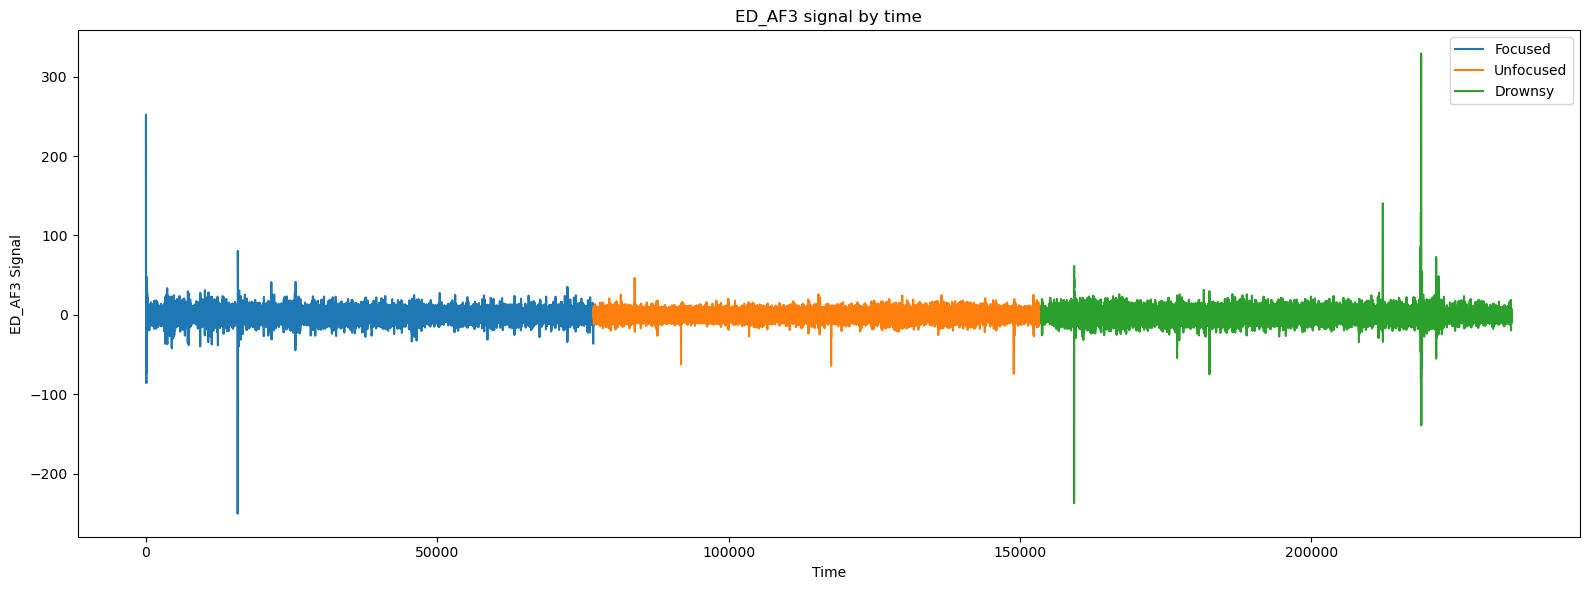

In [18]:
plot_channel_signal(test_df, 'ED_AF3')

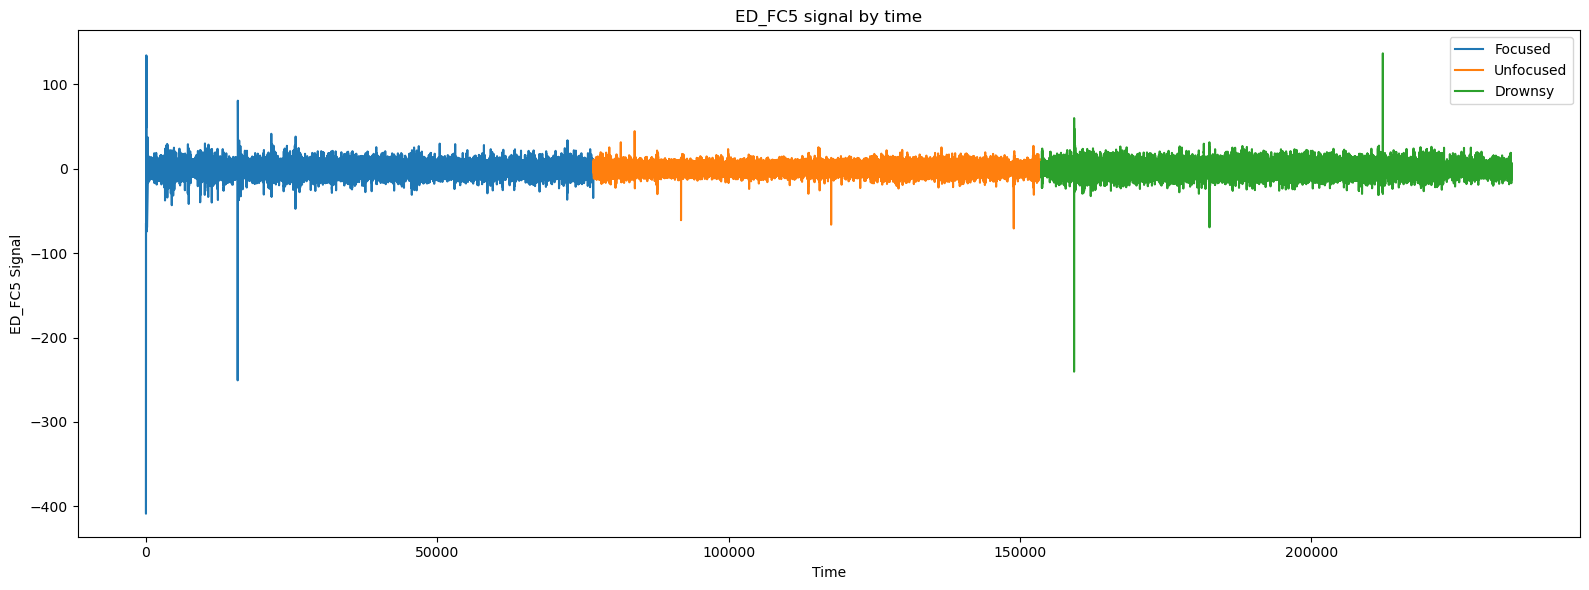

In [19]:
plot_channel_signal(test_df, 'ED_FC5')

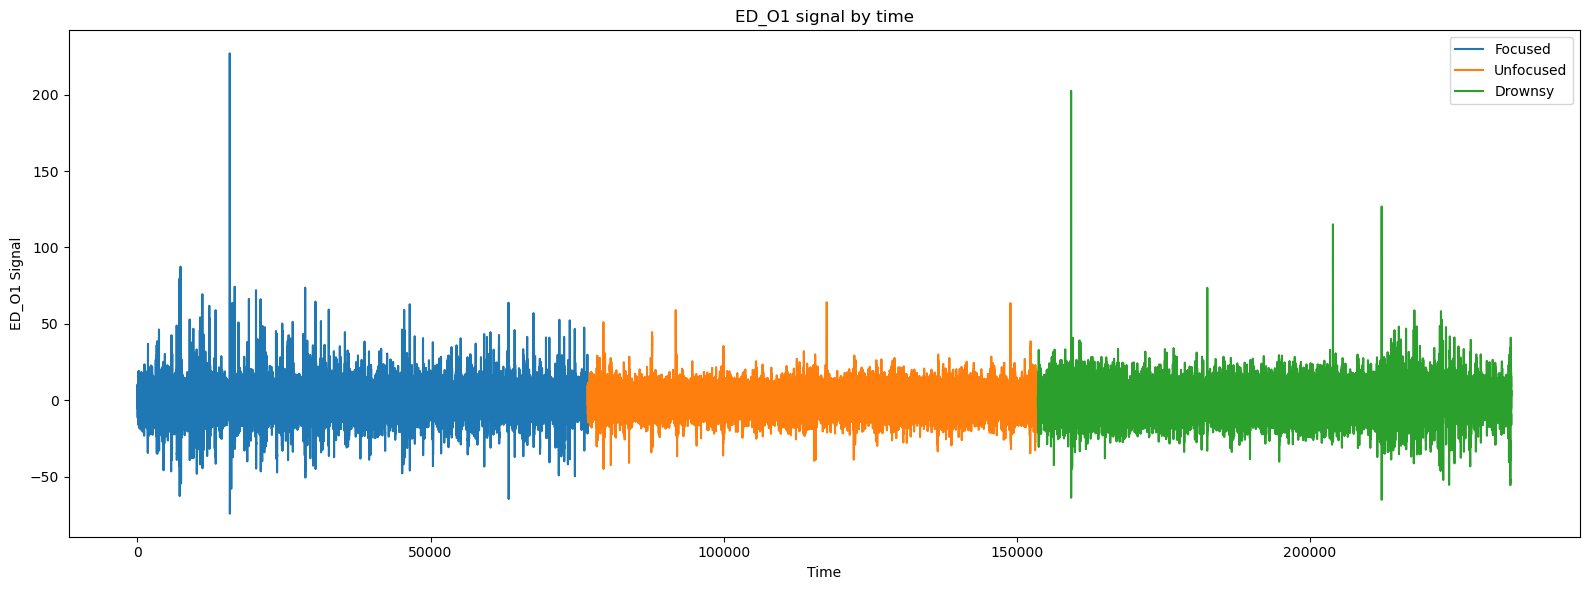

In [20]:
plot_channel_signal(test_df, 'ED_O1')

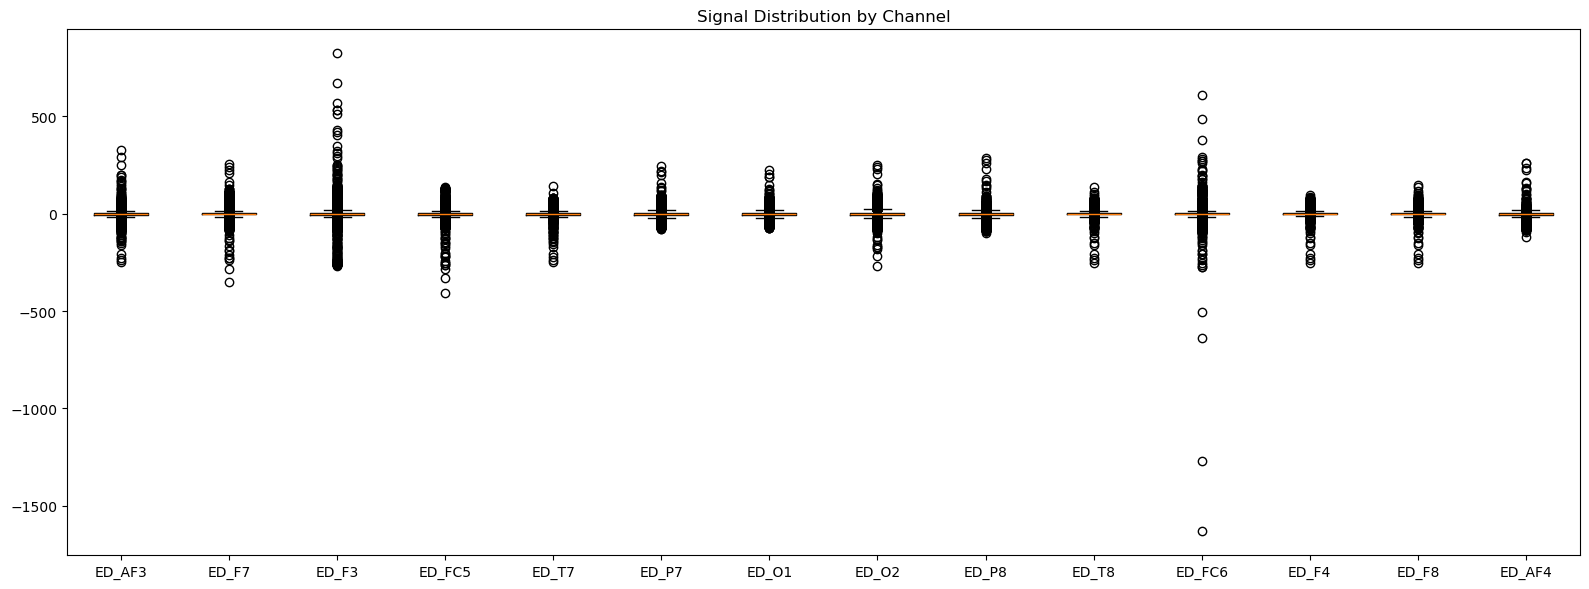

In [21]:
plt.figure(figsize=(16, 6))
plt.boxplot([test_df[column] for column in channel_columns], tick_labels=channel_columns)
plt.title('Signal Distribution by Channel')
plt.tight_layout()
plt.show()